# Initial value problems

---
Notes following [this book](https://websites.umich.edu/~mejn/cp/index.html).

Say we want to find the solution to a partial differential equation (PDE) evolves with time given some initial conditions. A common example is the 1D diffusion equation

$$
\frac{\partial \phi}{\partial t} = D \frac{\partial^2 \phi}{\partial x^2}
$$

where $D$ is the diffusion coefficient and $\phi(x, t)$ depends on both position $x$ and time $t$. Well, in the [boundary value notebook](boundary.ipynb), we found that we could solve for PDEs with functions of the form $f(x, y)$ (two independent variables) by laying out a grid of discrete points, defining the values on the boundaries, and relaxing the system toward a solution. So we might imagine that we could do the same with time. For the 1D example above, we would have a line of spaced out $x$ values that we could drag downward in time $t$ to create a similar grid of points $\{(x, t)\}$. This, however, will not work because we do not know all of the boundary conditions for the system. We would know the boundary conditions at the top of the grid at $t = 0$ -- these are our initial conditions -- but we would not know the boundary conditions at the bottom of the grid, as they occur at a point in time that we have not observed yet! The whole point of initial value problems is to find out how our solution evolves with time! So we need to try something else.

---

# The FTCS method (forward-time centered-space)

For our 1D diffusion equation we start by dividing the spatial dimension, $x$, into a grid of discrete points. This is simply a line along the $x$-axis with evenly spaced points a distance $a$ apart. 

First, we'll rewrite the spatial derivative second derivative as

$$
\frac{\partial^2 \phi}{\partial x^2} = \frac{\phi(x + a, t) + \phi (x - a, t)- 2\phi(x, t)}{a^2}
$$

For more information on how we got this, see the [numerical differentiation interlude](./boundary.ipynb#numerical_differentiation) in the previous notebook. So the diffusion equation becomes

$$
\frac{\partial \phi}{\partial t} = \frac{D}{a^2}  [\phi(x + a, t) + \phi (x - a, t)- 2\phi(x, t)]
$$

Recall that $\phi(x, t)$ is a function of its location on the $x$-axis and the time. If we confine ourselves to a single value of $x$, and observe how the solution changes with time, we might as well write

$$
\phi(x, t) = \phi(t) |_x 
$$

So we have something like

$$
\frac{d \phi}{d t} = \frac{D}{a^2} [\phi(t)|_{x + a} + \phi (t)|_{x - a}- 2\phi(t)|_x]
$$

which looks an awful lot like an ordinary differential equation. In fact, this is exactly the approach we'll take! We can think of the $x$ grid point solutions as a set of simultaneous ODEs evolving with time. The only catch is that each solution for a point at $x$ depends on its immediate adjacent neighbors at $x \pm a$. This idea can be extended to functions like $f(x, y, t)$, $f(x, y, z, t)$, etc., where instead of using a line of points, we would use a grid, lattice, etc. of simultaneous ODEs.

Because we're now dealing with ODEs, we can use Euler's method, a Runge-Kutta method, etc. for solving them. In our case, we'll go with Euler's method even though it is typically less accurate than a Runge-Kutta method (it is a first-order RK method). Why? Well, the spatial second derivative approximation we made for $\frac{\partial^2 \phi}{\partial x^2}$ introduced second-order errors. So for an input $x$, the RHS will already not be very accurate. This means that solving the differential equation in $t$, $\frac{\partial \phi}{\partial t}$, will not be very accurate either. Euler's method contains second-order errors that are comparable in size to those coming from the second derivative, so we might as well use it since its simple.

Recall that Euler's method for solving a differential equation of the form

$$
\frac{d\phi}{dt} = f(\phi, t)
$$

is to Taylor expand $\phi(t)$ about time $t$ and write

$$
\phi(t + h) \approx \phi(t) + h \frac{d\phi}{dt} = \phi(t) + h f(\phi, t)
$$

Applying this to our diffusion equation, we have

$$
\phi(x, t + h) \approx \phi(x, t) + h \frac{D}{a^2}  [\phi(x + a, t) + \phi (x - a, t)- 2\phi(x, t)]
$$

So if we know the value of $\phi$ at every grid point $x$ at some time $t$, then this equation tells us the value at every grid point at time $t + h$.

---

# Heat equation example

Let's apply this to a simple example using the heat (diffusion) equation

$$
\frac{\partial T}{\partial t} = D \frac{\partial^2 T}{\partial x^2}
$$

Suppose we have a stainless steel barrier $1$ cm thick initially at $20^\circ\text{C}$ everywhere. We then place cold water at $0^\circ\text{C}$ below it, and hot water at $50^\circ\text{C}$ above it. Thermal conduction is governed by the heat equation, so we can solve the 1D heat equation for the temperature $T(x)$ as a function of its position between the two water bodies. 

We will divide the $x$-axis region between the water into 100 equal grid intervals, meaning that there are 101 grid points dividing them. The temperatures at $x=0$ and $x=100$ are fixed at $T(0) = 50^\circ\text{C}$ and $T(100) = 0^\circ\text{C}$, respectively. Everywhere in between starts at $T(x) = 20^\circ\text{C}$, and is allowed to change with time. We could also have the points at the end change with time as well (water cooling / heating), but we won't for this example. The thermal diffusivity for stainless steel is $D = 4.25 \times 10^{-6} m^2 s^{-1}$.

We'll plot the spatial temperature profiles at 5 different times to see how they change.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML

In [10]:
# constants
L = 0.01          # thickness of steel in m
D = 4.25e-6       # thermal diffusivity of steel in m^2/s
N = 100           # number of divisions in grid
a = L/N           # grid spacing
h = 1e-4          # time-step
epsilon = h/1000  # small number to prevent division by zero

# initial conditions
Tlo = 0.0         # temperature at left end
Tmid = 20.0       # temperature at middle
Thi = 50.0        # temperature at right end

# times to plot
t1 = 0.01           
t2 = 0.1            
t3 = 0.4            
t4 = 1.0            
t5 = 10.0           
tend = t5 + epsilon 

In [11]:
# set up the temperature array
T = np.empty(N+1,float) 
T[0] = Thi
T[1: N] = Tmid
T[N] = Tlo

# temporary array for the new temperature
Tp = np.empty(N+1,float) 
Tp[0] = Thi
Tp[N] = Tlo

We see that the temperature is hotter near the warm water source and cooler near the cold water source. At first, the temperature of the intermediate region is constant and flat according to our initial conditions. However, as time goes on a gradient appears between the high and low temperatures.

If the heat sources were also allowed to change temperature, then we would see the entire system move toward a flat, equilibrium temperature.

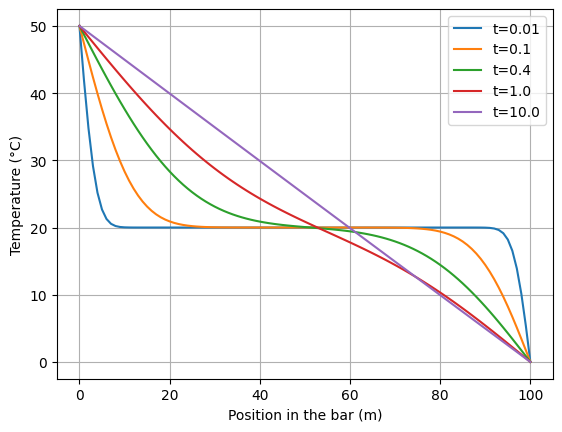

In [12]:
t = 0.0
c = h*D/(a*a)   # prefactor
while t < tend:
    # calculate the new values of T
    Tp[1:N] = T[1:N] + c*(T[2:N+1] + T[0:N-1] - 2*T[1:N])
    # for i in range(1,N):
    #     Tp[i] = T[i] + c*(T[i+1] + T[i-1] - 2*T[i])
    T,Tp = Tp,T
    t += h

    # t is a float, so comparisons are made by checking if the difference is less than epsilon
    if abs(t-t1)<epsilon:
        plt.plot(T, label="t=0.01")
    if abs(t-t2)<epsilon:
        plt.plot(T, label="t=0.1")
    if abs(t-t3)<epsilon:
        plt.plot(T, label="t=0.4")
    if abs(t-t4)<epsilon:
        plt.plot(T, label="t=1.0")
    if abs(t-t5)<epsilon:
        plt.plot(T, label="t=10.0")
plt.legend()
plt.grid(True)
plt.xlabel("Position in the bar (m)")
plt.ylabel("Temperature (°C)")
plt.show()

Let's make a cool animation! This time, we'll let `T` be an array of shape (T, N+1), where N+1 is the number of grid points to measure the temperature (N = number of intervals), and T is the total number of time steps. This way, we can save the temperature history at every point along the $x$-axis. `T[t]` gives the temperature profile at a time `t`.

In [ ]:
# constants
L = 0.01                # thickness of steel in m
D = 4.25e-6             # thermal diffusivity of steel in m^2/s
N = 100                 # number of divisions in grid
a = L/N                 # grid spacing
h = 1e-4                # time-step size
c = h*D/(a*a)           # diffusion prefactor
tend = 10.0             # time to run to
num_steps = int(tend/h) # number of time-steps

# initial conditions
Tlo = 0.0         # temperature at left end
Tmid = 20.0       # temperature at middle
Thi = 50.0        # temperature at right end

# set up the temperature array
T = np.empty((num_steps, N+1), float)
T[:, 0] = Thi           # the first column is fixed in time
T[0, 1:N] = Tmid       # only set the first row to initial conditions 
T[:, N] = Tlo           # the last column is fixed in time
T.shape

In [ ]:
for t in range(1, num_steps):
    # calculate the new values of T
    # the current time step, t, is calculated from the previous time step, t-1
    T[t, 1:N] = T[t-1, 1:N] + c*(T[t-1, 2:N+1] + T[t-1, 0:N-1] - 2*T[t-1, 1:N])

The gif can be found [here](diffusion.gif).

In [ ]:
from matplotlib import animation
from IPython.display import HTML

# create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

fig.suptitle("Temperature evolution in a steel bar")

# initialize the line object for the animated plot
line, = ax1.plot([], [], "r-", label="Temperature")

# set the limits and labels for the animated plot
ax1.set_xlim(0, L)
ax1.set_ylim(0, Thi)
# ax1.set_xlabel("Position in the bar (m)")
ax1.xaxis.set_visible(False)
ax1.set_ylabel("Temperature (°C)")
ax1.grid(True)

# initialize the image object for the temperature history
im = ax2.imshow(np.zeros((1, N+1)), cmap="hot", aspect="auto", extent=[0, L, 0, 1], vmin=Tlo, vmax=Thi)
ax2.set_xlabel("Position in the bar (m)")
# cbar_ax = fig.add_axes([0.05, 0.1, 0.03, 0.35])
# cbar = fig.colorbar(im, cax=cbar_ax)
ax2.yaxis.set_visible(False)

# initialize the text object for the current time
time_text = ax1.text(0.98, 0.95, "", transform=ax1.transAxes, ha='right')

# function to initialize the animation
def init():
    im.set_data(np.zeros((1, N+1)))
    line.set_data([], [])
    time_text.set_text("")
    return im, line, time_text

# function to update the animation at each frame
def animate(frame):
    x = np.linspace(0, L, N+1)
    y = T[frame]
    im.set_data([y])
    line.set_data(x, y)
    time_text.set_text(f"Time: {frame*h:.2f} s")
    return im, line, time_text

# select a subset of frames to animate
frame_step = 200                 # number of time steps between frames
max_frame = int(num_steps/2.2)   # the solution converges before the end, so don't animate the whole thing
frames = range(0, max_frame, frame_step)

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=frames, init_func=init,
                               interval=50, blit=True)

# save the animation as an HTML file
html_animation = anim.to_jshtml()

# save the animation as a gif file
anim.save("diffusion.gif", writer="pillow", fps=30)

# display the animation in the notebook
plt.tight_layout()
plt.close()  # close the static plot
HTML(html_animation)

In [15]:
# Image(filename="diffusion.gif")
display(HTML('<img src="diffusion.gif" />')) # to display on github

---

# FTCS numerical instability

We can try out the FTCS method again, but this time on the wave equation. We'll see that it will fail spectacularly over time for reasons we'll very briefly discuss later. Given $\phi(x, t)$, the 1D wave equation is 


$$
\frac{\partial^2 \phi}{\partial t^2} = \nu^2 \frac{\partial^2 \phi}{\partial x^2}
$$

and describes the propagation of a wave, say, over a rope. As before, we will first approximate the spatial second derivative 

$$
\frac{d^2 \phi}{d t^2} = \frac{\nu^2}{a^2}[\phi(x+a, t) + \phi(x - a, t) - 2 \phi(x, t)]
$$

Unlike the diffusion equation above, the wave equation has a second derivative in time on the LHS. Because of this, we'll have to split it up into two first-order ODEs in order to solve it. We will define a new variable $\psi$ and decompose the above equation into

\begin{align*}
\frac{d \phi}{dt} &= \psi(x, t) \\
\frac{d \psi}{dt} &= \frac{\nu^2}{a^2}[\phi(x+a, t) + \phi(x - a, t) - 2 \phi(x, t)]
\end{align*}

Next, we'll simply apply Euler's method to each of the equations to solve for the respective values at a time $t+h$

\begin{align*}
\phi(x, t+h) &= \phi(x, t) + h \frac{d \phi}{dt} = \phi(x, t) + h  \psi(x, t)\\
\psi(x, t+h) &= \psi(x, t) + h \frac{d \psi}{dt} = \psi(x, t) + h\frac{\nu^2}{a^2}[\phi(x+a, t) + \phi(x - a, t) - 2 \phi(x, t)]
\end{align*}

To be clear, $\phi(x, t)$ is the displacement of the wave at point $x$ at time $t$. In other words, it gives the instantaneous amplitude of the wave. $\psi(x, t)$ is the time derivative of $\phi$, making it the rate of change / velocity of the displacement. It tells us how quickly the string moves up or down at a point $x$ at time $t$. Now we can apply FTCS to an example system and see what happens. 

Suppose we have a string of length $L$ that we strike at time $t = 0$. The wave will propagate at $\nu = 100 \text{ ms}^{-1}$ with the initial condition that $\phi(x, t=0) = 0$ everywhere, meaning that the string is flat. The velocity $\psi(x, t=0)$ is nonzero, with profile

$$
\psi(x, t) = C \frac{x(L-x)}{L^2} \exp \left[-\frac{(x-d)^2}{2 \sigma^2} \right]
$$

where $L = 1$ m, $d = 10$ cm, $C = 1 \text{ ms}^{-1}$, and $\sigma = 0.3$ m. The string is bounded at its ends $x=0$ and $x = L$.

In [13]:
# constants
L = 1.0                       # length of string in m
d = 0.1                       # distance from x=0 in m
nu = 100                      # wave speed in m/s
C = 1.0                       # amplitude of wave in m/s
N = 200                       # number of grid divisions
sigma = 0.3                   # standard deviation of Gaussian pulse
a = L/N                       # grid spacing in m
h = 5.0005e-5                 # time step size in s
total_time = 100.0e-3         # time to run to in s
num_steps = int(total_time/h) # number of time steps

# get a grid of x values
# x_grid = np.linspace(0, L, N+1)
x_grid = np.arange(0, L+a, a)    # so we can use a :)  

# grid of initial displacement values -- all zeros
# we initialize it as (num_steps, N+1) to store the values at each time step
phi_grid = np.zeros((num_steps, N+1), float)

# velocity profile
def psi(x: float, d:float, sigma:float, C:float, L:float) -> float:
    return C * x*(L - x)/L**2 * np.exp(-(x-d)**2 / (2*sigma**2))

# set the initial velocity profile at t = 0 based on the x positions
psi_grid = np.zeros((num_steps, N+1), float)
psi_grid[0] = psi(x_grid, d, sigma, C, L)

psi_grid.shape

(1999, 201)

First, let's visualize that initial velocity profile at time $t = 0$.

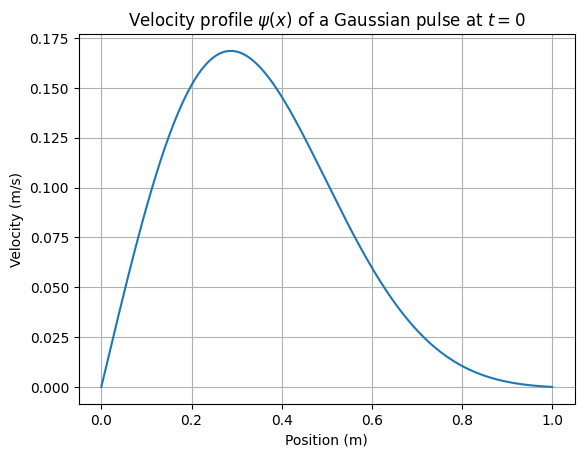

In [14]:
plt.plot(x_grid, psi_grid[0])
plt.title(r"Velocity profile $\psi(x)$ of a Gaussian pulse at $t=0$")
plt.xlabel("Position (m)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.show()

I found that this was taking forever to animate in a notebook, so you can find the the code [here](wave_equation.py). The corresponding gif is [here](wave.gif).



In [17]:
display(HTML('<img src="wave.gif" />'))